In [1]:
from astropy.table import Table
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import yaml
from astropy.modeling.models import BlackBody
import astropy.units as u
from astropy import constants

In [2]:
sns.set_context("talk")
sns.set_color_codes()

In [3]:
datapath = Path.cwd().parent.parent / "data-jesus"

In [4]:
regions = "BS", "YSO", "bkg", "bkg2"
bands = "SL1", "SL2", "LL1", "LL2"
def _load_spectrum(region, band):
    try:
        return Table.read(
            str(datapath / "NGC346_spec" / f"ngc346_{region}_final_{band}.tbl"),
            format="ascii.ipac"
        )
    except FileNotFoundError:
        return None

data = {
    region: {
        band: _load_spectrum(region, band)
        for band in bands
    }
    for region in regions
}

In [5]:
data["bkg2"]

{'SL1': <Table length=117>
 WAVELENGTH   FLUX  
     um     MJy / sr
  float64   float64 
 ---------- --------
   7.533706 2.441026
   7.595799 3.264344
   7.657894 3.350521
   7.719988 2.027686
   7.782082 2.229759
   7.844176 2.375424
   7.906271 1.816658
   7.968365 2.363079
   8.030458 2.165712
        ...      ...
   14.17779 4.446922
   14.23988 4.135509
   14.30198 4.628242
   14.36407 5.022763
   14.42616 4.639732
   14.48826 4.765847
   14.55035 4.487456
   14.61245 4.167167
   14.67454 4.186294
   14.73664 4.484834,
 'SL2': <Table length=77>
 WAVELENGTH    FLUX   
     um      MJy / sr 
  float64    float64  
 ---------- ----------
   5.242817  0.3647428
   5.273802    0.60383
   5.304788  0.4558865
   5.335773   1.063213
   5.366758  0.6880401
   5.397744  0.9822417
   5.428729 -0.1901394
   5.459714   0.104542
     5.4907   0.792398
        ...        ...
   7.318837  0.9425146
   7.349822   1.212888
   7.380807   1.164099
   7.411793   2.062589
   7.442778    3.10732
   7.

In [6]:
line_list = yaml.safe_load(open(datapath / "spitzer-lines.yaml"))
line_list

[{'wave': 9.7, 'label': 'H_2'},
 {'wave': 6.36829, 'label': '[Ar III]'},
 {'wave': 5.982, 'label': '[K IV]'},
 {'wave': 6.985274, 'label': '[Ar II]'},
 {'wave': 7.447, 'label': '[Cl IV]'},
 {'wave': 7.90158, 'label': '[Ar V]'},
 {'wave': 8.99138, 'label': '[Ar III]'},
 {'wave': 10.0354, 'label': '[Cl II]'},
 {'wave': 11.759, 'label': '[Cl IV]'},
 {'wave': 13.10219, 'label': '[Ar V]'},
 {'wave': 17.8846, 'label': '[P III]'},
 {'wave': 20.3, 'label': '[Cl IV]'},
 {'wave': 21.8291, 'label': '[Ar III]'},
 {'wave': 6.2, 'label': 'PAH'},
 {'wave': 7.7, 'label': 'PAH'},
 {'wave': 8.6, 'label': 'PAH'},
 {'wave': 11.2, 'label': 'PAH'},
 {'wave': 12.7, 'label': 'PAH'},
 {'wave': 5.582821, 'label': 'He II'},
 {'wave': 6.947984, 'label': 'He II'},
 {'wave': 9.713475, 'label': 'He II'},
 {'wave': 6.85233342, 'label': 'He I'},
 {'wave': 7.455, 'label': 'He I'},
 {'wave': 12.36651414669, 'label': 'He I'},
 {'wave': 19.05394155783, 'label': 'He I'},
 {'wave': 7.459858, 'label': 'H I'},
 {'wave': 8.84,

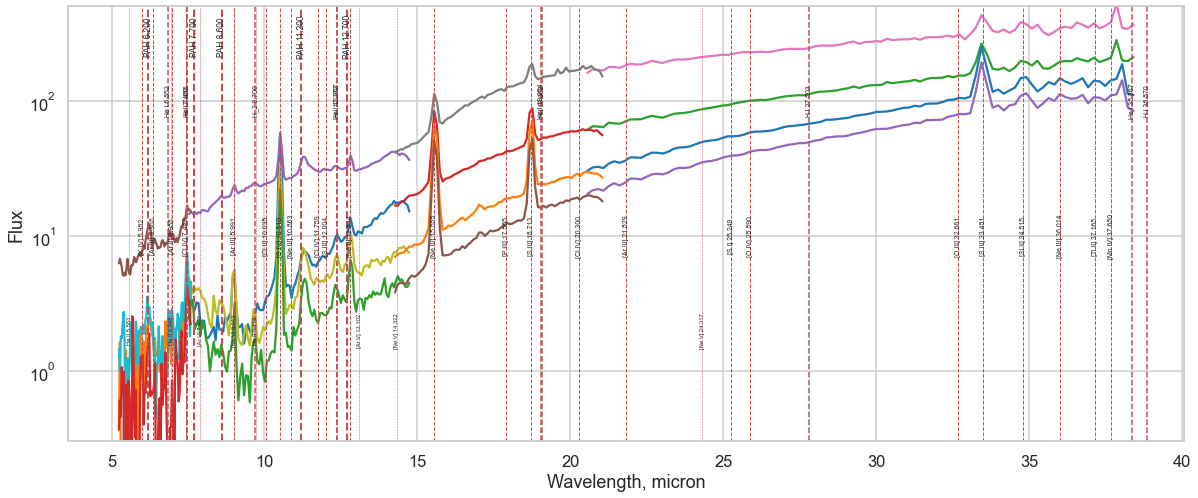

In [7]:
fig, ax = plt.subplots(
    figsize=(20, 8),
)
for region in regions:
    for band in bands:
        if data[region][band]:
            ax.plot("WAVELENGTH", "FLUX", data=data[region][band])
for linedata in line_list:
    if 'elow' in linedata and linedata['elow'] > 1e4:
        # Highly excited configuration
        continue
    elif linedata['label'].split()[-1].startswith("V") or linedata['label'] == "He II":
        # Highly ionized
        linewidth = 0.5
        y0 = 2.0
        fontsize = 'xx-small'
    elif linedata['label'].startswith('PAH'):
        # PAH band
        linewidth = 2.0
        y0 = 300.0
        fontsize = 'small'
    elif linedata['label'].startswith('H'):
        # Hydrogen, Helium, or H_2 line
        linewidth = 1.5
        y0 = 100.0
        fontsize = 'x-small'
    else:
        # Ground configuration
        linewidth = 1.0
        y0 = 10.0
        fontsize = 'x-small'
    ax.axvline(linedata['wave'], linestyle='dashed', color='r', linewidth=linewidth)
    ax.text(
        linedata['wave'], y0, f"{linedata['label']} {linedata['wave']:.3f}",
        ha="center", va="center", rotation="vertical", fontsize=fontsize,
    )

ax.set(
    yscale="log",
    ylim=[0.3, 500],
    ylabel="Flux",
    xlabel="Wavelength, micron",
)
fig.savefig('jesus-spitzer-spectra.pdf', bbox_inches='tight')
...;

### Take ratios with respect to the background

In [8]:
for region in regions:
    for band in bands:
        data[region][band]["RATIO"] = data[region][band]["FLUX"] / data["bkg2"][band]["FLUX"]

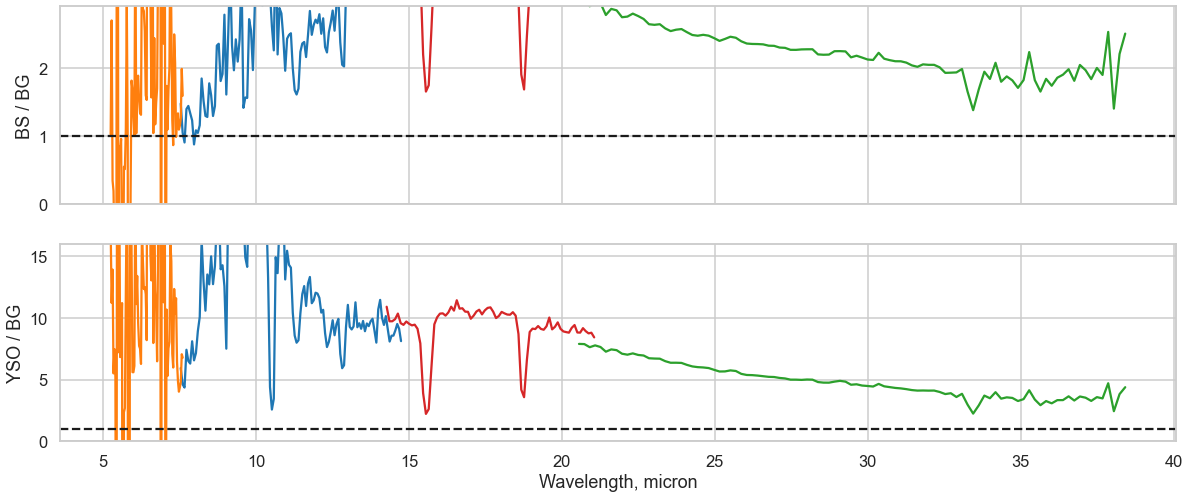

In [9]:
fig, [ax, axx] = plt.subplots(
    2, 1, sharex=True,
    figsize=(20, 8),
)
for band in bands:
    ax.plot("WAVELENGTH", "RATIO", data=data["BS"][band])
    axx.plot("WAVELENGTH", "RATIO", data=data["YSO"][band])
for a in ax, axx:
    a.axhline(1.0, color='k', linestyle='dashed')
ax.set(
    ylim=[0., 2.9],
    ylabel="BS / BG",
)
axx.set(
    ylim=[0., 16],
    ylabel="YSO / BG",
    xlabel="Wavelength, micron",
)
fig.savefig('jesus-spitzer-ratios.pdf', bbox_inches='tight')
...;

### Subtract BG

Mixture of the two BG regions.  Aim is to get the [S III] lines to disappear on the BG-subtracted BS spectrum

In [33]:
mix2 = 0.7
mix1 = 1 - mix2

for region in regions:
    for band in bands:
        bg = mix1 * data["bkg"][band]["FLUX"] + mix2 * data["bkg2"][band]["FLUX"]
        data[region][band]["BGSUB"] = data[region][band]["FLUX"] - bg

Compare with  a black body


In [34]:
((u.cm / u.s) * u.MJy / u.sr / u.micron ** 2).to(u.erg / u.s / u.cm**2 / u.sr / u.micron)
#(u.MJy / u.sr).to(u.erg / u.s / u.cm**2 / u.sr / u.Hz)

1.0000000000000003e-13

In [50]:
waves = np.linspace(5.0, 40.0, 200) * u.micron
bb = BlackBody(
    temperature=135 * u.K,
    scale=5e-15 * constants.c * u.MJy / u.sr / u.micron ** 2,
)

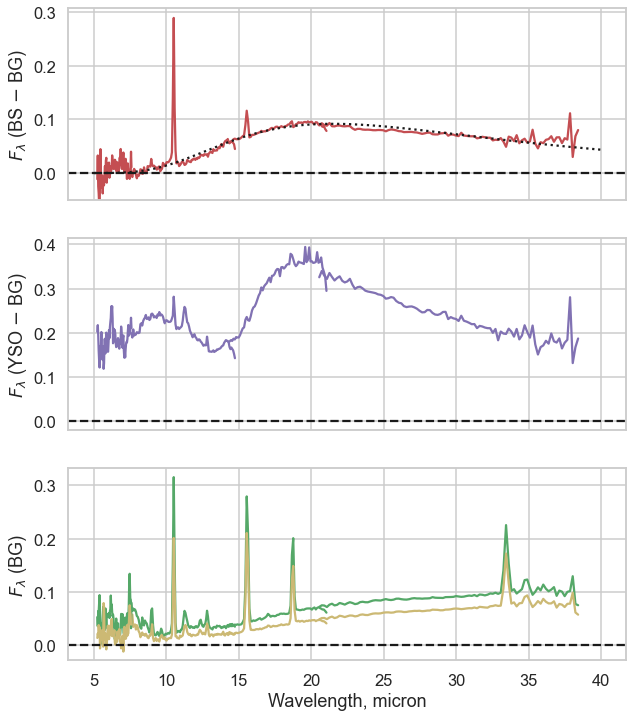

In [51]:
fig, [ax, axx, axxx] = plt.subplots(
    3, 1, sharex=True,
    figsize=(10, 12),
)
for band in bands:
    d = data["BS"][band]
    ax.plot(d["WAVELENGTH"], d["BGSUB"] / d["WAVELENGTH"]**2, color='r')
    d = data["YSO"][band]
    axx.plot(d["WAVELENGTH"], d["BGSUB"] / d["WAVELENGTH"]**2, color='m')
    d = data["bkg"][band]
    axxx.plot(d["WAVELENGTH"], d["FLUX"] / d["WAVELENGTH"]**2, color='g')
    d = data["bkg2"][band]
    axxx.plot(d["WAVELENGTH"], d["FLUX"] / d["WAVELENGTH"]**2, color='y')
ax.plot(waves, bb(waves) / constants.c, color="k", linestyle="dotted")
for a in ax, axx, axxx:
    a.axhline(0.0, color='k', linestyle='dashed')
ax.set(
    ylim=[-0.05, None],
    ylabel=r"$F_\lambda$ (BS $-$ BG)",
)
axx.set(
    ylim=[None, None],
    ylabel=r"$F_\lambda$ (YSO $-$ BG)",
)
axxx.set(

    ylim=[None, None],
    ylabel=r"$F_\lambda$ (BG)",
    xlabel="Wavelength, micron",
)
fig.savefig('jesus-spitzer-bgsub.pdf', bbox_inches='tight')
...;

In [52]:
bb.lambda_max.to(u.micron)

<Quantity 21.46497745 micron>

In [53]:
(constants.c / bb.nu_max).to(u.micron)

<Quantity 37.77365423 micron>

Use modified BB using Cloudy opacities

In [54]:
opac_tab = Table.read("../../data/xsec-infrared-dust-silicate_ism_10.ecsv")
wavgrid = opac_tab["Wavelength"].data * u.micron
kappa_s = opac_tab["Opacity"].data
opac_tab = Table.read("../../data/xsec-infrared-dust-graphite_ism_10.ecsv")
fac = 1.5
kappa_c = fac * opac_tab["Opacity"].data

In [55]:
bb_s = BlackBody(
    temperature=140 * u.K,
    scale=2.8e-15 * constants.c * u.MJy / u.sr / u.micron ** 2,
)
bb_ss = BlackBody(
    temperature=350 * u.K,
    scale=2.8e-15 * constants.c * u.MJy / u.sr / u.micron ** 2,
)
bb_c = BlackBody(
    temperature=120 * u.K,
    scale=2.8e-15 * constants.c * u.MJy / u.sr / u.micron ** 2,
)
mbb_sed_s = wavgrid * kappa_s * bb_s(wavgrid) / constants.c
mbb_sed_ss = wavgrid * (kappa_s + 4 * kappa_c) * bb_ss(wavgrid) / constants.c
hfac = 0.0008
mbb_sed_ss *= hfac
mbb_sed_c = wavgrid * kappa_c * bb_c(wavgrid) / constants.c
fac = 1.5
mbb_sed_c *= fac
mbb_sed = mbb_sed_s + mbb_sed_ss + mbb_sed_c
mbb_sed_c *= 7 / mbb_sed.max()
mbb_sed_s *= 7 / mbb_sed.max()
mbb_sed_ss *= 7 / mbb_sed.max()
mbb_sed *= 7 / mbb_sed.max()

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Or the same, but the SED

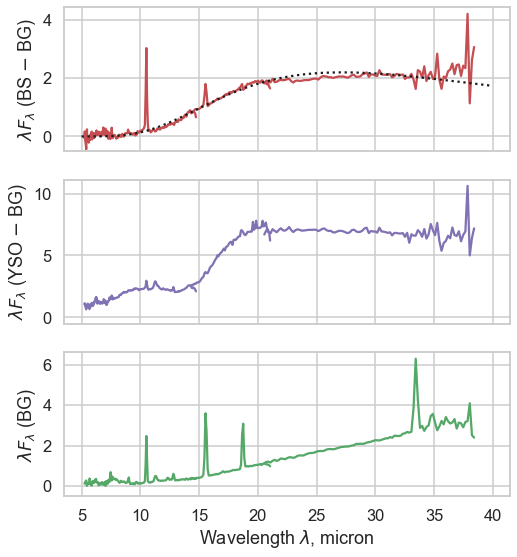

In [58]:
fig, [ax, axx, axxx] = plt.subplots(
    3, 1, sharex=True,
    figsize=(8, 9),
)
for band in bands:
    d = data["BS"][band]
    ax.plot(d["WAVELENGTH"], d["BGSUB"] / d["WAVELENGTH"], color='r')
    d = data["YSO"][band]
    axx.plot(d["WAVELENGTH"], d["BGSUB"] / d["WAVELENGTH"], color='m')
    d1 = data["bkg"][band]
    d2 = data["bkg2"][band]
    axxx.plot(d["WAVELENGTH"], (mix1 * d1["FLUX"] + mix2 * d2["FLUX"]) / d["WAVELENGTH"], color='g')
ax.plot(waves, waves * bb(waves) / constants.c, color="k", linestyle="dotted")
# axx.plot(wavgrid, mbb_sed, color="k", linestyle="dotted")
# axx.plot(wavgrid, mbb_sed_c, color="r", linestyle="dotted")
# axx.plot(wavgrid, mbb_sed_s, color="c", linestyle="dotted")
# axx.plot(wavgrid, mbb_sed_ss, color="y", linestyle="dotted")

# axxx.plot(waves, 1e3 * waves * bb2(waves) / constants.c, color="k", linestyle="dotted")
ax.set(
    ylim=[-0.5, None],
    ylabel=r"$\lambda F_\lambda$ (BS $-$ BG)",
)
axx.set(
    ylim=[-0.5, None],
    ylabel=r"$\lambda F_\lambda$ (YSO $-$ BG)",
)
axxx.set(
    xlim=[3.5, 41.5],
    ylim=[-0.5, None],
    yticks=[0, 2, 4, 6],
    ylabel=r"$\lambda F_\lambda$ (BG)",
    xlabel=r"Wavelength $\lambda$, micron",
)
# for a in ax, axx, axxx:
#     a.set_yscale("symlog", linthresh=0.5, linscale=0.1)
#     a.set_xscale("log")
fig.savefig('jesus-spitzer-bgsub-sed.pdf', bbox_inches='tight')
...;

In the end I did not need any if the modified bb curves for the YSO spectrum, since none of them were much good.  It is possible to get the dip between the two silicate peaks fitted pretty well, but not at the same time as the long and short wavelengths


### Look at all the dust opacity files

In [213]:
opac_files = (Path.cwd().parent.parent / "data").glob('xsec-infrared-dust-*.ecsv')
opacities = {p.stem.split('-')[-1]: Table.read(str(p)) for p in opac_files}
opacities

{'pah1_c15': <Table length=8229>
       Wavelength              Opacity        
         micron                cm2 / g        
        float64                float64        
 ---------------------- ----------------------
       29953355.5312221 1.4099119962144877e-09
     29853687.470518664 1.4146190244013875e-09
     29754350.431862213 1.4193416890277944e-09
      29655354.05956434 1.4240804499889878e-09
     29556669.404115513  1.428834387494409e-09
      29458325.35234515 1.4336048812298959e-09
     29360302.745928753 1.4383910114048904e-09
     29262611.078401014 1.4431927780193917e-09
      29165240.91704216 1.4480111008639593e-09
                    ...                    ...
    1.6486803235969e-08 2.5696487785360268e-17
 1.6000727050580018e-08 2.3365526956422866e-17
  1.552897882831471e-08  2.124601218019587e-17
 1.5071139247576677e-08 1.9318761224566357e-17
 1.4626797736887966e-08 1.7566334860531196e-17
 1.4195557817713163e-08 1.5972871299896313e-17
 1.3777032327534442e-08 1.4

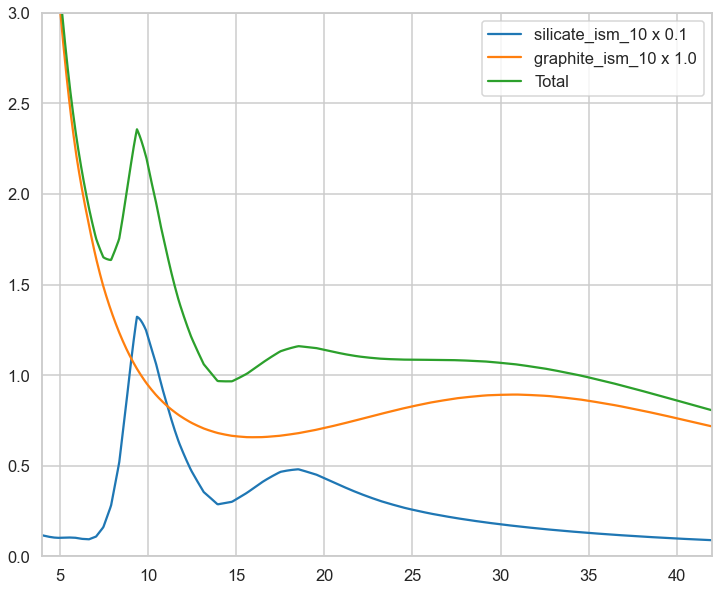

In [234]:
dtypes = "silicate_ism_10", "graphite_ism_10"
dweights = 0.1, 1.0
fig, ax = plt.subplots(figsize=(12, 10))
opac_sum = np.zeros_like(kappa)
for label, weight in zip(dtypes, dweights):
    ax.plot(wavgrid, weight * opacities[label]["Opacity"], label=f"{label} x {weight:.1f}")
    opac_sum += weight * opacities[label]["Opacity"]
ax.plot(wavgrid, opac_sum, label="Total")

ax.legend()
ax.set(xlim=[4, 42], ylim=[0.0, 3], yscale='linear')
...;